In [ ]:
# Purpose: The following is a program to fine-tune the pre-trained Google BERT transformer model for multi-class customer sentiment classifiction, 
#          given a spreadsheet with records of customer feedback in text and sentiment class labels ('1:Very Negative, 2:Negative, 3:Neutral, 4:Positive, and 5:Very Positive) 
#          This is an example program used for my Casualty Actuarial Society 2023 Annual Meeting presentation   
# By:      Frank Zhang - Oct 2023
# Reference: https://huggingface.co/docs/transformers/training

In [4]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

import warnings
warnings.simplefilter('ignore')
print(tf.__version__)
import os
 
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

2.13.0


In [ ]:
# this has the labelled sentiment -- labelled by ChatGPT with some mis-classified mannually corrected
# '1:Very Negative, 2:Negative, 3:Neutral, 4:Positive, and 5:Very Positive 
# Example: customer feedback like 'faster payment' was incorrectly put into '4:Positive', but should be '2:Negative'
df_comment_out_manual = pd.read_excel('./df_comment_out_manual.xlsx') 

In [84]:
df_comment_out_manual['Sentiment']=df_comment_out_manual['sentiment_gpt_manual'].str[:1].astype('int')-1
data_train, data_val  = train_test_split(df_comment_out_manual,test_size=0.2, random_state=123)
data_train.Sentiment.value_counts()

4    1146
2     453
1     404
3     335
0      28
Name: Sentiment, dtype: int64

In [85]:
# checking length of customer feedback text for idea of token length setting in fine-tuning - longer token takes more time
data_train.comments.str.len().value_counts()

10     43
21     33
15     28
18     28
20     27
       ..
522     1
530     1
294     1
386     1
669     1
Name: comments, Length: 425, dtype: int64

<AxesSubplot: title={'center': 'Pie chart of Sentiment Class'}, ylabel='sentiment_gpt_manual'>

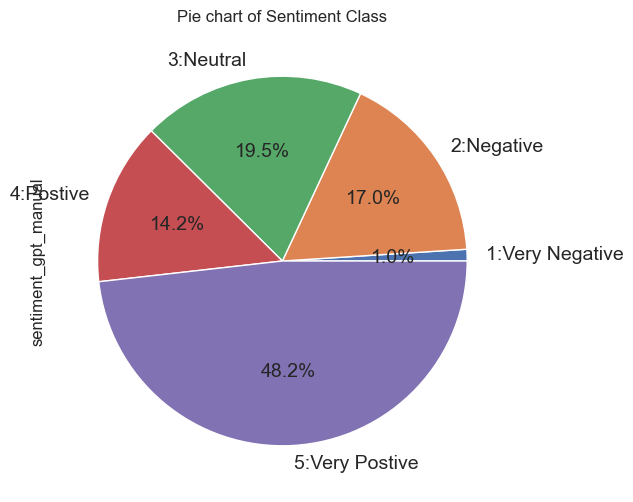

In [86]:
# checking distribution of the target variable
df2=df_comment_out_manual.copy(deep=True)
pie1=pd.DataFrame(df2['sentiment_gpt_manual'].value_counts().sort_index())
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'sentiment_gpt_manual',
          autopct='%1.1f%%', shadow=False, legend = False, fontsize=14, figsize=(6,6)) 

In [88]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [89]:
### ------- Build the model ------- ###

# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment.value_counts()), \
                    kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
                    name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model_bert_multiclass = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

# Take a look at the model
model_bert_multiclass.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPo   109482240 
                             olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 45, 768),                        
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                   

In [90]:
########## model fine-tuning ##########

# FZ: this works for tf version 2.3 and later
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-05,
    decay_steps=100,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
 
# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# model compiling
model_bert_multiclass.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# target variable in the training data
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input in the training data
x_train = tokenizer(
    text=data_train['comments'].values.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [91]:
# target variable in the validation data
y_val = to_categorical(data_val['Sentiment'])
# Tokenize the input in the validation data
x_val = tokenizer(
          text=data_val['comments'].values.tolist(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

In [98]:
# Fit the model
history = model_bert_multiclass.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=5,
    verbose=1)
# assess performance of the finetuned model on the validation data
model_bert_multiclass_eval = model_bert_multiclass.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)
y_val_predicted = model_bert_multiclass.predict(
    x={'input_ids': x_val['input_ids']},
)
y_val_predicted['Sentiment']
y_val
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]
y_val_actual_max=[np.argmax(i) for i in y_val]


Epoch 1/5
37/37 [==============================] - 856s 23s/step - loss: 0.5461 - accuracy: 0.8060 - val_loss: 0.7504 - val_accuracy: 0.7179
Epoch 2/5
37/37 [==============================] - 823s 22s/step - loss: 0.3669 - accuracy: 0.8770 - val_loss: 0.7780 - val_accuracy: 0.7179
Epoch 3/5
37/37 [==============================] - 837s 23s/step - loss: 0.2567 - accuracy: 0.9150 - val_loss: 0.8465 - val_accuracy: 0.7128
Epoch 4/5
37/37 [==============================] - 859s 23s/step - loss: 0.1602 - accuracy: 0.9510 - val_loss: 1.0216 - val_accuracy: 0.7264
Epoch 5/5
19/19 [==============================] - 57s 3s/step


In [99]:
report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.65      0.71      0.68        92
           2       0.60      0.66      0.63       114
           3       0.36      0.36      0.36        86
           4       0.89      0.84      0.87       295

    accuracy                           0.71       592
   macro avg       0.60      0.55      0.56       592
weighted avg       0.72      0.71      0.71       592



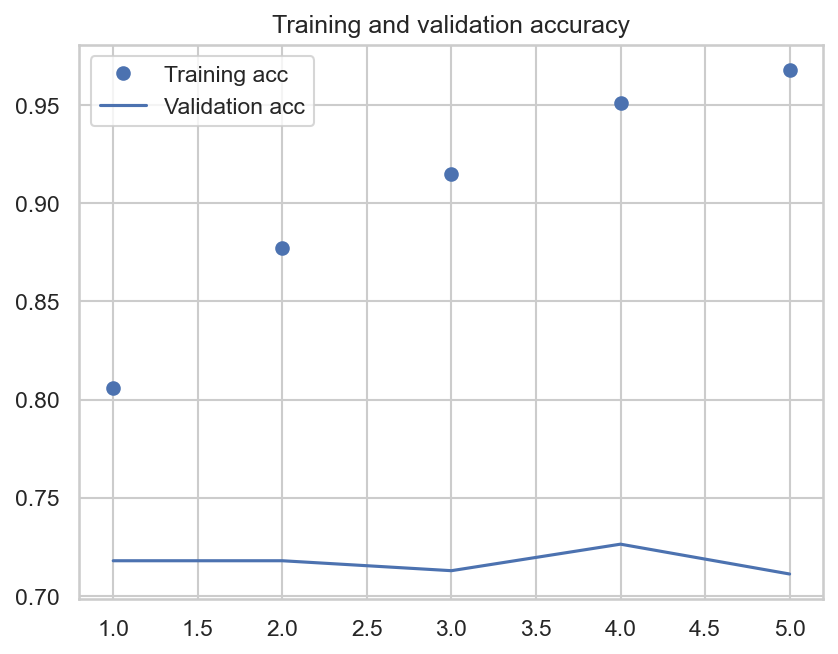

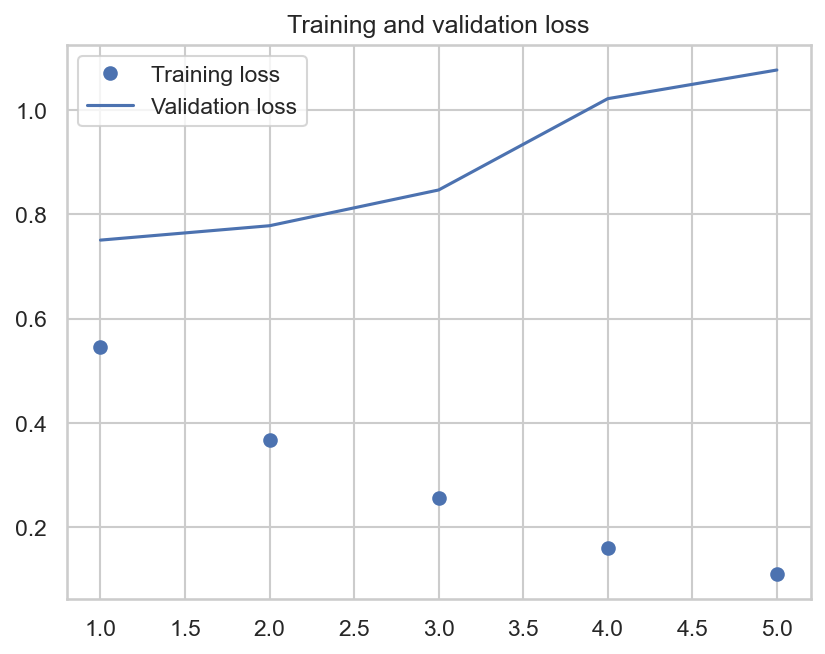

In [100]:
# plot out model accuracy change in response to # of epochs
# one epoch seems to good enough, consitent with finding in -- One Epoch Is All You Need https://www.arxiv-vanity.com/papers/1906.06669/
 
matplotlib.rcParams['figure.dpi'] = 150
 
# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

plot1(history)

In [101]:
# Save model for later use - first create finedtuned_model under the current work directory
for i in dir(model_bert_multiclass):
    if 'save' in i:
        print(i) 
model_bert_multiclass.save_weights('./finedtuned_model/fine_tuned_bert_multiclass_claim_sentiment_fz')

_export_to_saved_model_graph
_gather_saveables_for_checkpoint
_get_save_spec
_save_experimental
_saved_model_arg_spec
_saved_model_inputs_spec
_self_saveable_object_factories
_set_save_spec
_trackable_saved_model_saver
save
save_own_variables
save_spec
save_weights
